In [8]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_columns", None)

# -----------------------
# Load
# -----------------------
df = pd.read_parquet("ml_dataset.parquet")
print(df.head(1))
print(df.shape)

TIME_COL = "time_hour"
TARGET   = "trips"

# -----------------------
# Ensure proper datetime + sort
# -----------------------
df = df.copy()
df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")
df = df.dropna(subset=[TIME_COL]).sort_values(TIME_COL).reset_index(drop=True)

# -----------------------
# Aggregate to ONE ROW PER HOUR (citywide)
# IMPORTANT: Your df has city-hour trips REPEATED across many rows each hour,
# so we must use MEAN (or FIRST) for trips, NOT SUM.
# -----------------------
drop_like = ("station", "name", "id", "lat", "lon", "latitude", "longitude", "dock", "terminal")
exclude_cols = [c for c in df.columns if any(k in c.lower() for k in drop_like)]
exclude_cols = set(exclude_cols) | {TIME_COL, TARGET}

# Only aggregate numeric/bool columns
candidate_cols = [c for c in df.columns if c not in exclude_cols]
numeric_or_bool = [c for c in candidate_cols if pd.api.types.is_numeric_dtype(df[c]) or df[c].dtype == "bool"]

# Calendar/time flags are constant per hour -> keep first rather than mean
first_like = ("hour", "weekday", "day", "month", "season", "is_weekend", "is_holiday", "holiday")
first_cols = [c for c in numeric_or_bool if any(k in c.lower() for k in first_like)]

def mode_or_nan(x):
    m = x.mode(dropna=True)
    return m.iloc[0] if len(m) else np.nan

agg_dict = {TARGET: "mean"}  # <-- FIXED (was "sum")
for c in numeric_or_bool:
    if c == "precipitation_type":
        agg_dict[c] = mode_or_nan   # categorical-ish -> mode
    elif c in first_cols:
        agg_dict[c] = "first"       # time flags -> first
    else:
        agg_dict[c] = "mean"        # continuous weather -> mean

hourly = (
    df.groupby(TIME_COL, as_index=False)
      .agg(agg_dict)
      .sort_values(TIME_COL)
      .reset_index(drop=True)
)

print("\nHourly dataset shape:", hourly.shape)
print("Hourly trips stats:\n", hourly[TARGET].describe())

# -----------------------
# Add lag features (city-hour lags)
# -----------------------
hourly["trips_lag_1"]  = hourly[TARGET].shift(1)
hourly["trips_lag_24"] = hourly[TARGET].shift(24)
hourly = hourly.dropna(subset=["trips_lag_1", "trips_lag_24"]).reset_index(drop=True)

# -----------------------
# Proper time-based split (80/20)
# -----------------------
split_idx = int(len(hourly) * 0.8)
train = hourly.iloc[:split_idx].copy()
test  = hourly.iloc[split_idx:].copy()

X_train = train.drop(columns=[TARGET, TIME_COL])
y_train = train[TARGET].astype(float)

X_test  = test.drop(columns=[TARGET, TIME_COL])
y_test  = test[TARGET].astype(float)

# bool -> int
for c in X_train.columns:
    if X_train[c].dtype == "bool":
        X_train[c] = X_train[c].astype(int)
        X_test[c]  = X_test[c].astype(int)

# -----------------------
# Train XGBoost (no early stopping; compatible with older xgboost wrappers)
# -----------------------
from xgboost import XGBRegressor

model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=800,        # moderate since no early stopping
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
)

model.fit(X_train, y_train)

# -----------------------
# Evaluate: MAE, RMSE, R², Adj R², NMAE
# -----------------------
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 0, None)  # trips can't be negative

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

# Adj R² (mechanical; p = number of features)
n = len(y_test)
p = X_test.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# NMAE: normalize by mean of y_test (unitless)
den = float(np.mean(y_test))
nmae = mae / den if den != 0 else np.nan

print("\nRESULTS (City-hour aggregate + lags + time split + XGBoost)")
print("Train time range:", train[TIME_COL].iloc[0], "->", train[TIME_COL].iloc[-1])
print("Test  time range:", test[TIME_COL].iloc[0],  "->", test[TIME_COL].iloc[-1])

print(f"MAE     : {mae:.2f}")
print(f"RMSE    : {rmse:.2f}")
print(f"NMAE    : {nmae:.4f}  (MAE / mean(y_test))")
print(f"R²      : {r2:.6f}")
print(f"Adj. R² : {adj_r2:.6f}")

# -----------------------
# Feature importance (XGBoost)
# -----------------------
imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop feature importances:\n", imp.head(20))


   hour  day  weekday  is_weekend  wind_speed  windy_day  total_precipitation  \
0     0    1        3           0    4.467081          0             0.128778   

   rainy_day  precipitation_type  snowy_day  2m_temperature  is_holiday  \
0          0            1.000046          0       23.859295           0   

   month  season_Fall  season_Spring  season_Summer  season_Winter  time_hour  \
0      8        False          False           True          False 2024-08-01   

   trips  
0    135  
(4702154, 19)

Hourly dataset shape: (8759, 18)
Hourly trips stats:
 count    8759.000000
mean      536.836854
std       503.891950
min         1.000000
25%       112.500000
50%       391.000000
75%       829.000000
max      2670.000000
Name: trips, dtype: float64

RESULTS (City-hour aggregate + lags + time split + XGBoost)
Train time range: 2024-08-02 00:00:00 -> 2025-05-20 04:00:00
Test  time range: 2025-05-20 05:00:00 -> 2025-07-31 23:00:00
MAE     : 65.49
RMSE    : 107.39
NMAE    : 0.0967  (M

In [10]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

pd.set_option("display.max_columns", None)

TIME_COL = "time_hour"
TARGET   = "trips"

# -----------------------
# Helpers
# -----------------------
def nmae(y_true, y_pred):
    den = float(np.mean(y_true))
    return float(np.mean(np.abs(y_true - y_pred)) / den) if den != 0 else np.nan

def adj_r2_score(y_true, y_pred, p):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    if n <= p + 1:
        return np.nan
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def evaluate(y_true, y_pred, p):
    y_pred = np.clip(np.asarray(y_pred, dtype=float), 0, None)  # trips can't be negative
    out = {
        "MAE":  float(mean_absolute_error(y_true, y_pred)),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "NMAE": float(nmae(y_true, y_pred)),
        "R2":   float(r2_score(y_true, y_pred)),
        "AdjR2": float(adj_r2_score(y_true, y_pred, p)),
    }
    return out

def print_header(title):
    print("\n" + "=" * 80)
    print(title)
    print("=" * 80)

def format_metrics(m):
    return (f"MAE={m['MAE']:.2f} | RMSE={m['RMSE']:.2f} | NMAE={m['NMAE']:.4f} | "
            f"R²={m['R2']:.6f} | AdjR²={m['AdjR2']:.6f}")

# -----------------------
# Load + clean
# -----------------------
df = pd.read_parquet("ml_dataset.parquet")
df = df.copy()
df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")
df = df.dropna(subset=[TIME_COL]).sort_values(TIME_COL).reset_index(drop=True)

print_header("RAW DATA")
print(f"Shape: {df.shape}")
print(df.head(1))

# -----------------------
# City-hour aggregate
# NOTE: trips are constant within an hour in your raw df, so we use MEAN (not SUM).
# -----------------------
drop_like = ("station", "name", "id", "lat", "lon", "latitude", "longitude", "dock", "terminal")
exclude_cols = [c for c in df.columns if any(k in c.lower() for k in drop_like)]
exclude_cols = set(exclude_cols) | {TIME_COL, TARGET}

candidate_cols = [c for c in df.columns if c not in exclude_cols]
numeric_or_bool = [c for c in candidate_cols if pd.api.types.is_numeric_dtype(df[c]) or df[c].dtype == "bool"]

first_like = ("hour", "weekday", "day", "month", "season", "is_weekend", "is_holiday", "holiday")
first_cols = [c for c in numeric_or_bool if any(k in c.lower() for k in first_like)]

# Make precip_type categorical-ish at the source (helps mode be meaningful)
if "precipitation_type" in df.columns:
    df["precipitation_type"] = np.round(df["precipitation_type"]).astype("Int64")

def mode_or_nan(x):
    m = x.mode(dropna=True)
    return m.iloc[0] if len(m) else np.nan

agg = {TARGET: "mean"}
for c in numeric_or_bool:
    if c == "precipitation_type":
        agg[c] = mode_or_nan
    elif c in first_cols:
        agg[c] = "first"
    else:
        agg[c] = "mean"

hourly = (
    df.groupby(TIME_COL, as_index=False)
      .agg(agg)
      .sort_values(TIME_COL)
      .reset_index(drop=True)
)

# clean tiny negative precip noise (common with reanalysis)
if "total_precipitation" in hourly.columns:
    hourly["total_precipitation"] = hourly["total_precipitation"].clip(lower=0)

print_header("CITY-HOUR DATASET")
print(f"Shape: {hourly.shape}")
print("Trips stats:\n", hourly[TARGET].describe())

# -----------------------
# Add lags (true time-series lags)
# -----------------------
hourly["trips_lag_1"]  = hourly[TARGET].shift(1)
hourly["trips_lag_24"] = hourly[TARGET].shift(24)
hourly = hourly.dropna(subset=["trips_lag_1", "trips_lag_24"]).reset_index(drop=True)

# -----------------------
# Time-based split
# -----------------------
split_idx = int(len(hourly) * 0.8)
train = hourly.iloc[:split_idx].copy()
test  = hourly.iloc[split_idx:].copy()

X_train = train.drop(columns=[TARGET, TIME_COL])
y_train = train[TARGET].astype(float)

X_test  = test.drop(columns=[TARGET, TIME_COL])
y_test  = test[TARGET].astype(float)

# bool -> int
for c in X_train.columns:
    if X_train[c].dtype == "bool":
        X_train[c] = X_train[c].astype(int)
        X_test[c]  = X_test[c].astype(int)

print_header("TRAIN/TEST RANGE")
print("Train:", train[TIME_COL].iloc[0], "->", train[TIME_COL].iloc[-1], f"({len(train)} rows)")
print("Test :", test[TIME_COL].iloc[0],  "->", test[TIME_COL].iloc[-1],  f"({len(test)} rows)")

# -----------------------
# Baselines (sanity)
# -----------------------
print_header("BASELINES")
p = X_test.shape[1]
m_lag1 = evaluate(y_test.values, test["trips_lag_1"].values, p)
m_lag24 = evaluate(y_test.values, test["trips_lag_24"].values, p)
print("Lag-1 :", format_metrics(m_lag1))
print("Lag-24:", format_metrics(m_lag24))

# -----------------------
# Models
# -----------------------
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=400, random_state=42, n_jobs=-1,
        max_depth=None, min_samples_leaf=2
    ),
    "GradientBoosting": GradientBoostingRegressor(
        random_state=42, n_estimators=500, learning_rate=0.05, max_depth=3
    ),
}

# XGBoost (optional; if not installed, it will skip)
try:
    from xgboost import XGBRegressor
    models["XGBoost"] = XGBRegressor(
        objective="reg:squarederror",
        n_estimators=800,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
    )
except Exception as e:
    print("\n[Note] XGBoost not available in this environment:", repr(e))

print_header("MODEL RESULTS (CITY-HOUR)")
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    met = evaluate(y_test.values, y_pred, p)
    results.append({"Model": name, **met})

res_df = pd.DataFrame(results).sort_values("RMSE")
print(res_df.to_string(index=False, formatters={
    "MAE": "{:.2f}".format,
    "RMSE": "{:.2f}".format,
    "NMAE": "{:.4f}".format,
    "R2": "{:.6f}".format,
    "AdjR2": "{:.6f}".format,
}))

# -----------------------
# Feature importance / coefficients (clean output)
# -----------------------
print_header("TOP FEATURES / COEFFICIENTS")

# 1) Linear regression coefficients
if "LinearRegression" in models:
    lr = models["LinearRegression"]
    coef_df = (pd.DataFrame({"feature": X_train.columns, "coef": lr.coef_})
               .assign(abs_coef=lambda d: d["coef"].abs())
               .sort_values("abs_coef", ascending=False)
               .drop(columns="abs_coef"))
    print("\nLinearRegression top coefficients:")
    print(coef_df.head(15).to_string(index=False, formatters={"coef": "{:.6f}".format}))

# 2) RandomForest feature importances
if "RandomForest" in models and hasattr(models["RandomForest"], "feature_importances_"):
    rf = models["RandomForest"]
    imp = (pd.DataFrame({"feature": X_train.columns, "importance": rf.feature_importances_})
           .sort_values("importance", ascending=False))
    print("\nRandomForest top importances:")
    print(imp.head(15).to_string(index=False, formatters={"importance": "{:.6f}".format}))

# 3) GradientBoosting feature importances
if "GradientBoosting" in models and hasattr(models["GradientBoosting"], "feature_importances_"):
    gb = models["GradientBoosting"]
    imp = (pd.DataFrame({"feature": X_train.columns, "importance": gb.feature_importances_})
           .sort_values("importance", ascending=False))
    print("\nGradientBoosting top importances:")
    print(imp.head(15).to_string(index=False, formatters={"importance": "{:.6f}".format}))

# 4) XGBoost feature importances
if "XGBoost" in models and hasattr(models["XGBoost"], "feature_importances_"):
    xgbm = models["XGBoost"]
    imp = (pd.DataFrame({"feature": X_train.columns, "importance": xgbm.feature_importances_})
           .sort_values("importance", ascending=False))
    print("\nXGBoost top importances:")
    print(imp.head(15).to_string(index=False, formatters={"importance": "{:.6f}".format}))



RAW DATA
Shape: (4702154, 19)
   hour  day  weekday  is_weekend  wind_speed  windy_day  total_precipitation  \
0     0    1        3           0    4.467081          0             0.128778   

   rainy_day  precipitation_type  snowy_day  2m_temperature  is_holiday  \
0          0            1.000046          0       23.859295           0   

   month  season_Fall  season_Spring  season_Summer  season_Winter  time_hour  \
0      8        False          False           True          False 2024-08-01   

   trips  
0    135  

CITY-HOUR DATASET
Shape: (8759, 18)
Trips stats:
 count    8759.000000
mean      536.836854
std       503.891950
min         1.000000
25%       112.500000
50%       391.000000
75%       829.000000
max      2670.000000
Name: trips, dtype: float64

TRAIN/TEST RANGE
Train: 2024-08-02 00:00:00 -> 2025-05-20 04:00:00 (6988 rows)
Test : 2025-05-20 05:00:00 -> 2025-07-31 23:00:00 (1747 rows)

BASELINES
Lag-1 : MAE=197.12 | RMSE=274.53 | NMAE=0.2910 | R²=0.731904 | AdjR²=0

Hourly shape: (8759, 2)
count    8759.000000
mean      536.836854
std       503.891950
min         1.000000
25%       112.500000
50%       391.000000
75%       829.000000
max      2670.000000
Name: trips, dtype: float64


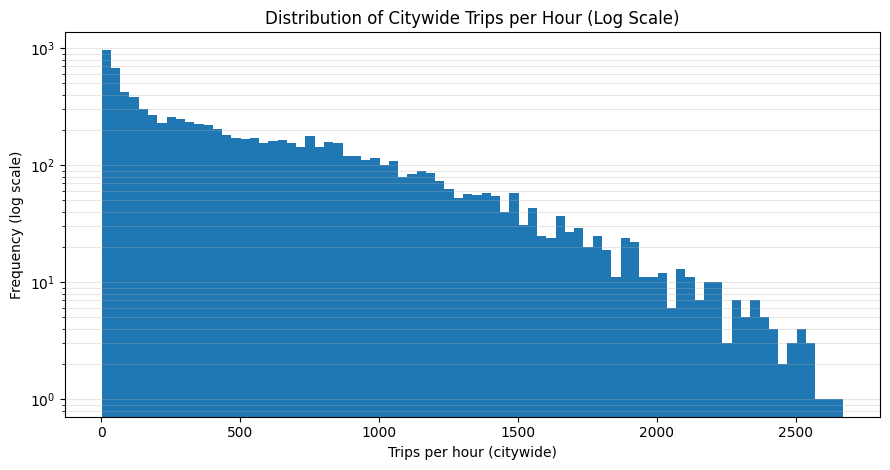

Saved: city_hour_trip_distribution_log.png


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TIME_COL = "time_hour"
TARGET   = "trips"

# -----------------------
# Load + build the SAME city-hour dataset from parquet
# -----------------------
df = pd.read_parquet("ml_dataset.parquet").copy()
df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")
df = df.dropna(subset=[TIME_COL]).sort_values(TIME_COL).reset_index(drop=True)

# City-hour trips are duplicated across rows within an hour in this parquet,
# so use MEAN (or FIRST) to recover the true citywide trips/hour.
hourly = (
    df.groupby(TIME_COL, as_index=False)
      .agg({TARGET: "mean"})
      .sort_values(TIME_COL)
      .reset_index(drop=True)
)

# If you'd like to remove the single missing hour effect, you can leave as-is.
# hourly[TARGET] = hourly[TARGET].astype(float)

print("Hourly shape:", hourly.shape)
print(hourly[TARGET].describe())

# -----------------------
# Plot: Distribution of Citywide Trips per Hour (log y-axis)
# -----------------------
x = hourly[TARGET].values

plt.figure(figsize=(9, 4.8))
# Choose bins that give a similar feel to your station plot.
# For citywide trips/hour (up to ~2670), 60–100 bins usually looks good.
plt.hist(x, bins=80)

plt.yscale("log")
plt.title("Distribution of Citywide Trips per Hour (Log Scale)")
plt.xlabel("Trips per hour (citywide)")
plt.ylabel("Frequency (log scale)")
plt.grid(True, which="both", axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("city_hour_trip_distribution_log.png", dpi=300)
plt.show()

print("Saved: city_hour_trip_distribution_log.png")


In [5]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

pd.set_option("display.max_columns", None)

PARQUET_PATH = "ml_dataset.parquet"
TOP20_CSV    = "top20_consensus_all.csv"

TIME_COL = "time_hour"
TARGET   = "trips"

# -----------------------
# Helpers
# -----------------------
def adj_r2(y_true, y_pred, p):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    if n <= p + 1:
        return np.nan
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def evaluate(y_true, y_pred, p):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    y_pred = np.clip(y_pred, 0, None)  # trips can't be negative
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    ar2  = adj_r2(y_true, y_pred, p)
    return float(mae), float(rmse), float(ar2)

def find_station_col(cols):
    # Try common names first
    common = ["station_id", "Station ID", "station", "stationId", "stationID", "start_station_id", "end_station_id"]
    for c in common:
        if c in cols:
            return c

    # Otherwise: heuristic search
    lower = {c: c.lower() for c in cols}
    candidates = [c for c in cols if ("station" in lower[c] and "id" in lower[c])]
    if len(candidates) == 1:
        return candidates[0]
    return None

# -----------------------
# Load data
# -----------------------
df = pd.read_parquet(PARQUET_PATH).copy()
df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")
df = df.dropna(subset=[TIME_COL]).sort_values(TIME_COL).reset_index(drop=True)

station_col = find_station_col(df.columns.tolist())
if station_col is None:
    raise ValueError(
        "Could not find a station id column in the parquet.\n"
        f"Columns found: {list(df.columns)}\n\n"
        "To run per-station models, the parquet must include something like 'station_id'."
    )

# -----------------------
# Load top-20 station list (FIRST 20 rows from CSV)
# -----------------------
top = pd.read_csv(TOP20_CSV)

# Find station id column in the CSV
csv_station_col = find_station_col(top.columns.tolist())
if csv_station_col is None:
    # fallback: if the first column looks like station IDs
    csv_station_col = top.columns[0]

top20_ids = (
    top[csv_station_col]
    .astype(str)
    .dropna()
    .iloc[:20]
    .tolist()
)

print("Using station column in parquet:", station_col)
print("Using station column in csv    :", csv_station_col)
print("Top 20 station IDs (from CSV):", top20_ids)

# Ensure station id is string for matching
df[station_col] = df[station_col].astype(str)

df20 = df[df[station_col].isin(top20_ids)].copy()
if df20.empty:
    raise ValueError("After filtering to the 20 station IDs, no rows remained. Check ID formats / column mapping.")

print("\nFiltered rows for top-20 stations:", df20.shape[0])

# Optional cleaning (recommended)
if "precipitation_type" in df20.columns:
    # Make it categorical-ish
    df20["precipitation_type"] = np.round(df20["precipitation_type"]).astype("Int64")
if "total_precipitation" in df20.columns:
    df20["total_precipitation"] = df20["total_precipitation"].clip(lower=0)

# -----------------------
# Train one XGB model per station and print summary table
# -----------------------
results = []

# Feature columns: exclude target, time, station id
feature_cols = [c for c in df20.columns if c not in [TARGET, TIME_COL, station_col]]

# bool -> int for ML
for c in feature_cols:
    if df20[c].dtype == "bool":
        df20[c] = df20[c].astype(int)

# XGB params (no early stopping / callbacks)
xgb_params = dict(
    objective="reg:squarederror",
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
)

# Keep the station order exactly as in CSV
for sid in top20_ids:
    dsi = df20[df20[station_col] == str(sid)].copy()
    dsi = dsi.sort_values(TIME_COL).reset_index(drop=True)

    # Build station-specific lags (true per-station time series)
    dsi["trips_lag_1"]  = dsi[TARGET].shift(1)
    dsi["trips_lag_24"] = dsi[TARGET].shift(24)
    dsi = dsi.dropna(subset=["trips_lag_1", "trips_lag_24"]).reset_index(drop=True)

    # If station has too few rows after lagging, skip gracefully
    if len(dsi) < 200:
        results.append({"Station ID": sid, "MAE": np.nan, "RMSE": np.nan, "Adj. R2": np.nan})
        continue

    # Train/test time split
    split_idx = int(len(dsi) * 0.8)
    train = dsi.iloc[:split_idx].copy()
    test  = dsi.iloc[split_idx:].copy()

    X_train = train[feature_cols + ["trips_lag_1", "trips_lag_24"]]
    y_train = train[TARGET].astype(float)

    X_test  = test[feature_cols + ["trips_lag_1", "trips_lag_24"]]
    y_test  = test[TARGET].astype(float)

    # bool->int already handled above, but enforce (in case station filtering changed dtypes)
    for c in X_train.columns:
        if X_train[c].dtype == "bool":
            X_train[c] = X_train[c].astype(int)
            X_test[c]  = X_test[c].astype(int)

    model = XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    p = X_test.shape[1]
    mae, rmse, ar2 = evaluate(y_test.values, y_pred, p)

    results.append({"Station ID": sid, "MAE": mae, "RMSE": rmse, "Adj. R2": ar2})

# -----------------------
# Print table like your screenshot
# -----------------------
res_df = pd.DataFrame(results)

# Match formatting (2 decimals for MAE/RMSE, 3 decimals for AdjR2)
res_df_fmt = res_df.copy()
res_df_fmt["MAE"] = res_df_fmt["MAE"].map(lambda x: "" if pd.isna(x) else f"{x:.2f}")
res_df_fmt["RMSE"] = res_df_fmt["RMSE"].map(lambda x: "" if pd.isna(x) else f"{x:.2f}")
res_df_fmt["Adj. R2"] = res_df_fmt["Adj. R2"].map(lambda x: "" if pd.isna(x) else f"{x:.3f}")

print("\nTable: XGBoost model performance for the top 20 stations")
print(res_df_fmt.to_string(index=False))

# --- MEAN METRICS ACROSS TOP 20 (simple average, ignores NaNs) ---
metrics_mean = res_df[["MAE", "RMSE", "Adj. R2"]].astype(float).mean(skipna=True)

print("\nMean performance across Top 20 stations (simple mean):")
print(f"Mean MAE     : {metrics_mean['MAE']:.2f}")
print(f"Mean RMSE    : {metrics_mean['RMSE']:.2f}")
print(f"Mean Adj. R² : {metrics_mean['Adj. R2']:.3f}")

# Optional: how many stations actually contributed (in case some were NaN)
valid_counts = res_df[["MAE", "RMSE", "Adj. R2"]].notna().sum()
print("\nStations contributing to mean:")
print(valid_counts.to_string())


# Optional save
res_df.to_csv("top20_station_xgb_results.csv", index=False)
print("\nSaved: top20_station_xgb_results.csv")


Using station column in parquet: start_station_id
Using station column in csv    : station_id
Top 20 station IDs (from CSV): ['M32006', 'M32018', 'M32011', 'B32005', 'A32010', 'C32008', 'M32042', 'B32002', 'A32002', 'D32016', 'B32016', 'M32037', 'B32034', 'B32062', 'B32037', 'B32015', 'A32004', 'M32004', 'D32010', 'M32061']

Filtered rows for top-20 stations: 805945

Table: XGBoost model performance for the top 20 stations
Station ID   MAE   RMSE Adj. R2
    M32006 51.53  91.88   0.965
    M32018 55.92  97.71   0.959
    M32011 64.27 109.11   0.951
    B32005 66.02 110.34   0.955
    A32010 71.56 118.23   0.953
    C32008 64.86 110.98   0.949
    M32042 61.94 109.58   0.946
    B32002 77.62 117.87   0.950
    A32002 76.86 122.55   0.938
    D32016 65.89 114.28   0.946
    B32016 74.65 129.64   0.929
    M32037 74.08 127.61   0.946
    B32034 67.77 109.26   0.951
    B32062 77.86 119.26   0.945
    B32037 84.17 127.44   0.943
    B32015 69.32 113.10   0.947
    A32004 85.16 130.23   0.9

MAE=65.88  RMSE=107.74  R2=0.958708


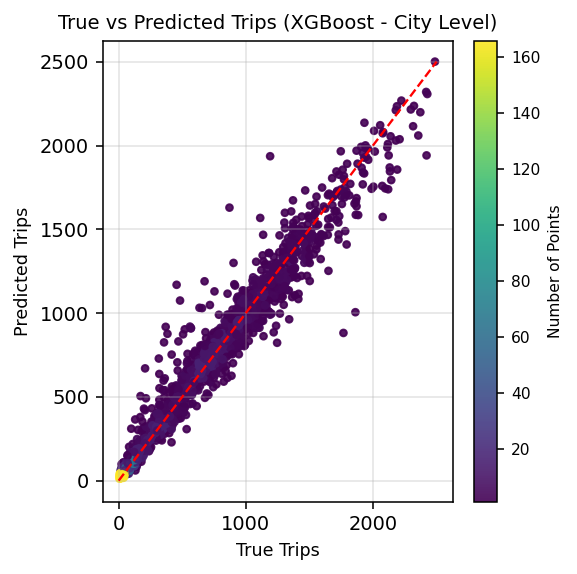

Saved: figures/XGB_city_scatter_new.png


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

TIME_COL = "time_hour"
TARGET   = "trips"

# -----------------------
# Load + build city-hour dataset (same as your corrected pipeline)
# -----------------------
df = pd.read_parquet("ml_dataset.parquet").copy()
df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")
df = df.dropna(subset=[TIME_COL]).sort_values(TIME_COL).reset_index(drop=True)

# Citywide trips/hour are duplicated across many rows in this parquet,
# so MEAN (or FIRST) correctly recovers total trips per hour.
non_target_cols = [c for c in df.columns if c not in [TIME_COL, TARGET]]

hourly = (
    df.groupby(TIME_COL, as_index=False)
      .agg({TARGET: "mean", **{c: "mean" for c in non_target_cols if pd.api.types.is_numeric_dtype(df[c])}})
      .sort_values(TIME_COL)
      .reset_index(drop=True)
)

# Clean tiny negative precipitation noise (optional)
if "total_precipitation" in hourly.columns:
    hourly["total_precipitation"] = hourly["total_precipitation"].clip(lower=0)

# Add lags
hourly["trips_lag_1"]  = hourly[TARGET].shift(1)
hourly["trips_lag_24"] = hourly[TARGET].shift(24)
hourly = hourly.dropna(subset=["trips_lag_1", "trips_lag_24"]).reset_index(drop=True)

# -----------------------
# Train/test split (time-based)
# -----------------------
split_idx = int(len(hourly) * 0.8)
train = hourly.iloc[:split_idx].copy()
test  = hourly.iloc[split_idx:].copy()

X_train = train.drop(columns=[TARGET, TIME_COL])
y_train = train[TARGET].astype(float)

X_test  = test.drop(columns=[TARGET, TIME_COL])
y_test  = test[TARGET].astype(float)

# bool -> int
for c in X_train.columns:
    if X_train[c].dtype == "bool":
        X_train[c] = X_train[c].astype(int)
        X_test[c]  = X_test[c].astype(int)

# -----------------------
# Train XGBoost (no early stopping)
# -----------------------
model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
)
model.fit(X_train, y_train)

y_pred = np.clip(model.predict(X_test), 0, None)

# Quick metrics print (optional)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
print(f"MAE={mae:.2f}  RMSE={rmse:.2f}  R2={r2:.6f}")

# -----------------------
# Build density coloring like your figure
# -----------------------
# 2D histogram bin counts -> map each point to its bin count
bins = 60
x = y_test.values
y = y_pred

H, xedges, yedges = np.histogram2d(x, y, bins=bins)
xi = np.clip(np.digitize(x, xedges) - 1, 0, H.shape[0]-1)
yi = np.clip(np.digitize(y, yedges) - 1, 0, H.shape[1]-1)
counts = H[xi, yi]

# -----------------------
# Plot (replicates style)
# -----------------------
plt.figure(figsize=(4.2, 4.2), dpi=140)

sc = plt.scatter(
    x, y,
    c=counts,
    s=12,
    alpha=0.9
)

# 45-degree reference line
m = max(np.max(x), np.max(y))
plt.plot([0, m], [0, m], "r--", linewidth=1.2)

plt.title("True vs Predicted Trips (XGBoost - City Level)", fontsize=10)
plt.xlabel("True Trips", fontsize=9)
plt.ylabel("Predicted Trips", fontsize=9)
plt.grid(True, alpha=0.35)

cbar = plt.colorbar(sc)
cbar.set_label("Number of Points", fontsize=8)
cbar.ax.tick_params(labelsize=8)

plt.tight_layout()

# Save
os.makedirs("figures", exist_ok=True)
out_path = "figures/XGB_city_scatter_new.png"
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)
